#### Case 2: Liquid hydrogen ($LH_2$) in a 2033 $\text{m}^3$ tank

This application corresponds to liquid hydrogen storage in the NASA's Space Launch System. It consists of a 2033 $m^3$ storage tank [NASA](https://www.energy.gov/sites/default/files/2021-10/new-lh2-sphere.pdf) in a tank with 8.4 m diameter and 40 m height. It will be assumed the following operation scenarios:

* Daily boil-off rate of 0.1%  
* Storage at atmospheric pressure with continuous removal of boil-off gas

For purposes of the example, it is assumed that the storage tank is passively insulated with perlite.

03/09/2024: Illustration of how to use SciPy to optimise

In [1]:
# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

#### Setup tank and cryogen properties


In [2]:
# Cylindrical storage tank properties
Q_roof = 0 # Roof heat ingress / W

# Vertically orientated cylindrical tank volume
V_tank = 2033 #m^3

# Aspect ratio
a = 0.5

# Diameter as a function of the aspect ratio
d_i = (4*V_tank/(a*np.pi))**(1/3) # Internal diameter / m
d_o = 1.02 * d_i   # External diameter / m
T_air = 293.15 # Temperature of the environment K

# Specify tank operating pressure
P = 101325 # Pa

# Initialise cryogen
hydrogen = Cryogen(name = "hydrogen")
hydrogen.set_coolprops(P)

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 3.73e-3 # W/m2/K
U_V = 3.73e-3 # W/m2/K

# At the tank bottom, the driving force is constant
q_b = U_L*(T_air - hydrogen.T_sat)

# Bottom heat flow
Q_b = q_b * np.pi * d_i**2/4 

LF = 0.95 # Initial liquid filling / Dimensionless
eta_w = 0.9 # Evaporative fraction

# Initialize mid-scale tank
mid_tank = Tank(d_i, d_o, V_tank, LF)
mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b, Q_roof, eta_w= eta_w)

# Keep the tank roof insulated
mid_tank.U_roof = 0 

# Set cryogen
mid_tank.cryogen = hydrogen

Calculate initial evaporation rate and transient period

In [3]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + hydrogen.name + " is %.1f kg/h" % (mid_tank.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % mid_tank.tau)

# Minimum number of hours to achieve steady state 
tau_h = (np.floor(mid_tank.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h )

# Calculate boil-off rate
BOR = (mid_tank.b_l_dot * 24 * 3600) / (mid_tank.V * mid_tank.LF * mid_tank.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR * 100))

The initial evaporation rate of hydrogen is 5.8 kg/h
Transient period = 167720.315 s 
Simulation time: 47 h
BOR = 0.102 %


### Simulation setup and execution

### Define optimisation parameters

In [7]:
# Define vertical spacing
dz = 0.05

# Calculate number of nodes
n_z = 1 + int(np.round(mid_tank.l_V/dz, 0))

# Define dimensionless computational grid
mid_tank.z_grid = np.linspace(0, 1, n_z)

# Define evaporation time as the transient period
evap_time = 3600*100

# Time step to plot each vapour temperature profile
mid_tank.plot_interval = evap_time/6

mid_tank.time_interval = 60

mid_tank.evaporate(evap_time)

### Plot response surface

### Visualisation of results

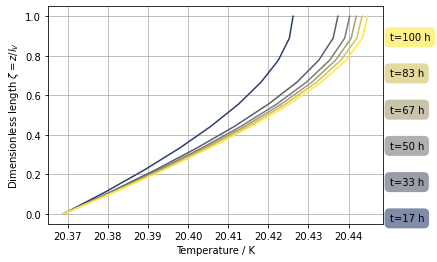

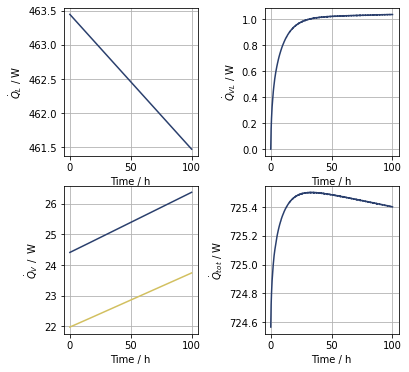

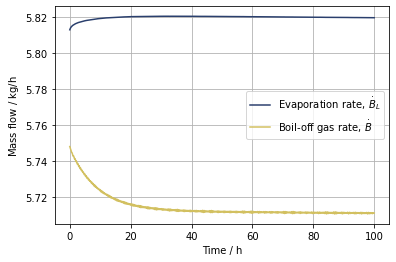

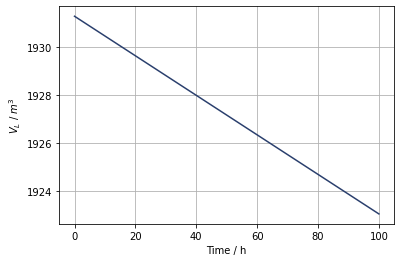

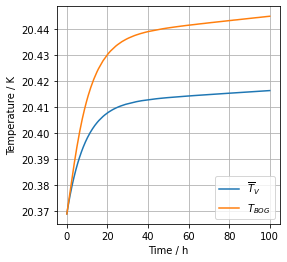

In [8]:
mid_tank.plot_tv(t_unit='h')
# Specify y-axis units as W, and time units to hours
mid_tank.plot_Q(unit = 'W', t_unit = 'h')
mid_tank.plot_BOG(unit='kg/h', t_unit='h')
mid_tank.plot_V_L(t_unit='h')
# Average vapour and BOG temperature
mid_tank.plot_tv_BOG(t_unit='h')


Text(0, 0.5, 'BOG')

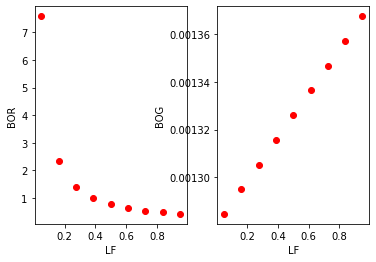

In [9]:
# Liquid filling
LF_vec = np.linspace(0.05, 0.95, 9)

# BOR objective function
f_list = []
# Total BOG objective function
f2_list = []

for LFi in LF_vec:
    # Update liquid filling
    mid_tank.LF = LFi

    # Execute simulation
    mid_tank.evaporate(evap_time)

    # Calculate objective function
    f = 1 - mid_tank.data['V_L'][-1] / mid_tank.data['V_L'][0]

    f2 = mid_tank.data['V_L'][0] - mid_tank.data['V_L'][1]

    # Append to list
    f_list.append(f)
    f2_list.append(f2)

f_list = np.array(f_list)
f2_list = np.array(f2_list)

fig, ax = plt.subplots(1,2)
# Plot
ax[0].plot(LF_vec, (100*f_list), 'ro')
ax[0].set_xlabel('LF')
ax[0].set_ylabel('BOR')
    
ax[1].plot(LF_vec, f2_list, 'ro')
ax[1].set_xlabel('LF')
ax[1].set_ylabel('BOG')

### Aspect ratio

l = %.3f m 2.958120304350667
l = %.3f m 4.695723282974739
l = %.3f m 6.153138191721197
l = %.3f m 7.453996079145667
l = %.3f m 8.649596241688993
l = %.3f m 9.767498038443932
l = %.3f m 10.824666520645287
l = %.3f m 11.832481217402668
l = %.3f m 12.799043213602108
l = %.3f m 13.730378173157291


Text(0, 0.5, 'BOG / kg / h')

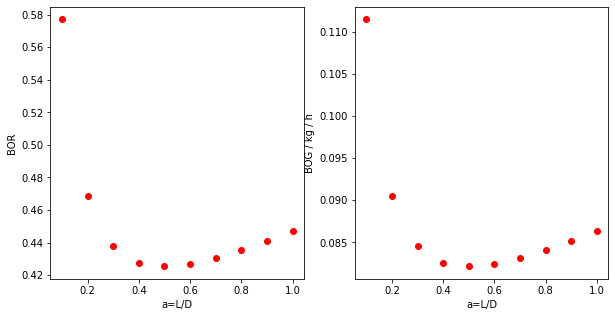

In [10]:
# Aspect ratio
a_vec = np.linspace(0.1, 1, 10)

# BOR objective function
f_list = []
# Total BOG objective function
f2_list = []

for a in a_vec:
    # Update aspect ratio
    mid_tank.LF = 0.95
    # a = 0.5
    d_i = (4*V_tank/(a*np.pi))**(1/3) # Internal diameter / m
    mid_tank.d_i = d_i
    mid_tank.d_o = 1.02 * d_i

    # Update  heat flow
    Q_b = q_b * np.pi * d_i**2/4 
    
    mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b, Q_roof, eta_w= eta_w)
    mid_tank.U_roof = 0 # Insulated roof
    # Calculate number of nodes
    #n_z = 1 + int(np.round(mid_tank.l_V/dz, 0))
    # Define dimensionless computational grid
    mid_tank.z_grid = np.linspace(0, 1, n_z)

    mid_tank.evaporate(evap_time)

    print("l = %.3f m", mid_tank.l)
    # Calculate objective function
    f = 1 - mid_tank.data['V_L'][-1] / mid_tank.data['V_L'][0]

    f2 = (mid_tank.data['V_L'][0] - mid_tank.data['V_L'][-1])/evap_time

    # Append to list
    f_list.append(f)
    f2_list.append(f2)

f_list = np.array(f_list)
f2_list = np.array(f2_list)

fig, ax = plt.subplots(1,2, figsize = [10,5])
# Plot
ax[0].plot(a_vec, (100*f_list), 'ro')
ax[0].set_xlabel('a=L/D')
ax[0].set_ylabel('BOR')
    
ax[1].plot(a_vec, (3600*f2_list), 'ro')
ax[1].set_xlabel('a=L/D')
ax[1].set_ylabel('BOG / kg / h')

In [ ]:
mid_tank.Q_L_in

In [ ]:
mid_tank.Q_b

In [ ]:
from scipy.optimize import Bounds, minimize

# Minimum and maximum practical ranges
# of initial liquid filling

# 5% represent ballast voyage
# 95% is the safety limit for potential liquid thermal expansion
bounds = Bounds([0.05], [0.95])

# Define objective function
def BOR_function(LF):

    # Update liquid filling
    mid_tank.LF = LF

    # Execute simulation
    mid_tank.evaporate(evap_time)

    # Calculate objective function
    f = 1 - mid_tank.data['V_L'][-1] / mid_tank.data['V_L'][0]
    
    print("LF = %.3f, f=%.3e" % (LF, f))
    return f    

# Initial liquid filling to optimise

x0 = 0.9 
res = minimize(BOR_function, x0, method='trust-constr', options={'verbose': 1}, bounds=bounds)

Global optimisation

In [ ]:
from scipy.optimize import Bounds, differential_evolution

# Minimum and maximum practical ranges
# of initial liquid filling
# 5% represent ballast voyage
# 95% is the safety limit for potential liquid thermal expansion
bounds = [(0.05, 0.95)]  # Bounds in differential_evolution are specified as a list of tuples

# Define objective function
def BOR_function(LF):

    # Update liquid filling
    mid_tank.LF = LF[0]  # LF is now an array, take the first element

    # Execute simulation
    mid_tank.evaporate(evap_time)

    # Calculate objective function
    
    # Liquid volume aet the end of the evaporation
    V_LF = mid_tank.data['V_L'][-1]

    # Liquid volume at the beginning
    V_L0 = mid_tank.data['V_L'][0]

    # Objective function
    f = 1 - V_LF/ V_L0
    
    print("LF = %.3f, V_L0=%.3f, V_LF = %.3f,, f=%.3e" % (LF[0], V_L0, V_LF, f))
    return f    

# Perform global optimization using differential evolution
result = differential_evolution(BOR_function, bounds, strategy='best1bin', maxiter=1000, popsize=15, tol=1e-6, mutation=(0.5, 1), recombination=0.7, disp=True)

# Results
print("Best solution found: LF =", result.x[0])
print("Function value:", result.fun)


#### References

U.S. Department of Energy. (2021, October). DOE/NASA Advances in Liquid Hydrogen Storage Workshop. Retrieved from [https://www.energy.gov/sites/default/files/2021-10/new-lh2-sphere.pdf]